In [30]:
import pandas as pd
import numpy as np
# from datetime import timedelta, datetime
# import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import klib

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_curve, plot_roc_curve, roc_auc_score

from imblearn.over_sampling import ADASYN

from tensorflow  import keras
from keras.models import Sequential
from keras import layers

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D,InputLayer
from tensorflow.keras.callbacks import TensorBoard,ReduceLROnPlateau,EarlyStopping
import tensorflow as tf
from tensorflow.keras.optimizers import SGD

import shap

##### 1.ID : Customer ID

##### 2.Age : Customer's age in completed years

##### 3.Experience : #years of professional experience

##### 4.Income : Annual income of the customer ($000)

##### 5.ZIP Code : Home Address ZIP code.

##### 6.Family : Family size of the customer

##### 7.CCAvg : Avg. spending on credit cards per month ($000)

##### 8.Education : Education Level. (1: Undergrad; 2: Graduate; 3: Advanced/Professional)

##### 9."Mortgage : Value of house mortgage if any. ($000)

##### 10.Personal Loan : Did this customer accept the personal loan offered in the last campaign?

##### 11.Securities Account : Does the customer have a securities account with the bank?

##### 12.CD Account : Does the customer have a certificate of deposit (CD) account with the bank?

##### 13.Online : Does the customer use internet banking facilities?

##### 14.Credit card : Does the customer use a credit card issued by

In [31]:
loans = pd.read_csv('Bank_Personal_Loan_Modelling.csv')

In [32]:
loans.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [33]:
loans.shape

(5000, 14)

In [34]:
len(loans['ZIP Code'].unique())

467

In [35]:
'''
Fix value into real ones.
'''
loans.CCAvg = loans.CCAvg*1000
loans.Mortgage = loans.Mortgage*1000

In [36]:
klib.missingval_plot(loans)

No missing values found in the dataset.


In [37]:
'''
Drop ID column cause i won't need it for my classification analysis.
'''
loans.drop(['ID'], axis=1, inplace=True)

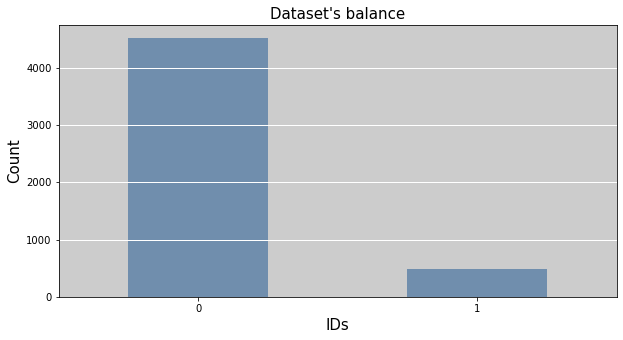

In [38]:
'''
Check the dataset and realise that is imbalanced, needs to be fixed with an oversampler.
'''
loans['Personal Loan'].value_counts().plot.bar(figsize=(10,5), color=(0.2, 0.4, 0.6, 0.6))
plt.title("Dataset's balance",size=15)
plt.xticks(rotation = 0)
plt.ylabel('Count',size=15)
plt.xlabel('IDs',size=15)
plt.grid(True,axis='y', color='w', linestyle='-', linewidth=1)
plt.gca().patch.set_facecolor('0.8')
plt.show()

In [39]:
'''
We can see that there are columns with large-scale numbers. We will need to scale the values. 
'''
loans.describe()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,45.338400,20.104600,73.774200,93152.503000,2.396400,1937.93800,1.881000,56498.800000,0.096000,0.104400,0.06040,0.596800,0.294000
std,11.463166,11.467954,46.033729,2121.852197,1.147663,1747.65898,0.839869,101713.802102,0.294621,0.305809,0.23825,0.490589,0.455637
min,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,91911.000000,1.000000,700.00000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,45.000000,20.000000,64.000000,93437.000000,2.000000,1500.00000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,55.000000,30.000000,98.000000,94608.000000,3.000000,2500.00000,3.000000,101000.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,67.000000,43.000000,224.000000,96651.000000,4.000000,10000.00000,3.000000,635000.000000,1.000000,1.000000,1.00000,1.000000,1.000000


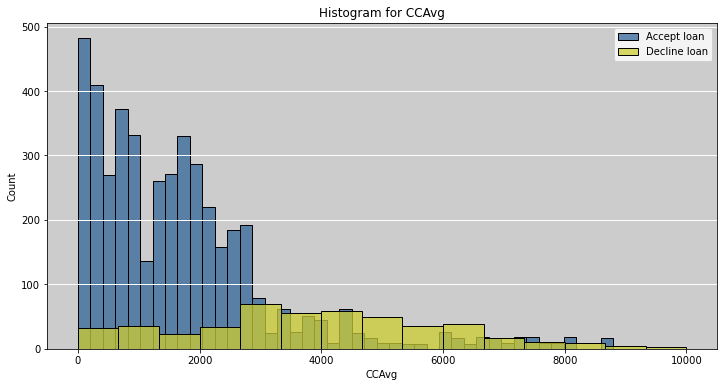

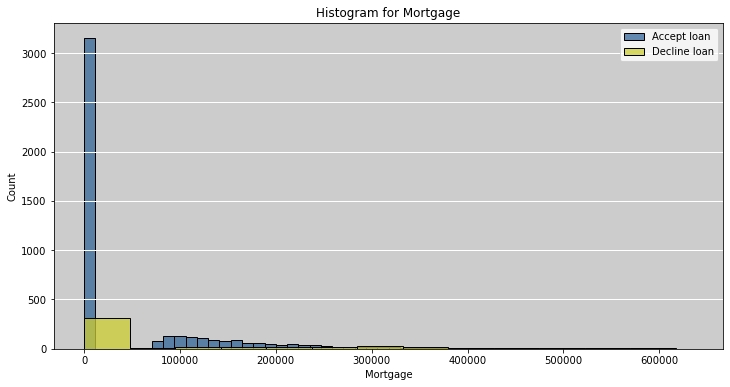

In [41]:
'''
Realise that these two columns are highly skewed.
'''
for i in ["CCAvg", "Mortgage"]:
    plt.figure(figsize=(12,6))
    decline_loan= loans[loans["Personal Loan"]==0]
    accept_loan= loans[loans["Personal Loan"]==1]
    sns.histplot(decline_loan[i], kde=False, color=(0.2, 0.4, 0.6, 0.6))
    sns.histplot(accept_loan[i], kde=False, color=(0.8, 0.8, 0.2, 0.2))
    plt.legend(["Accept loan", "Decline loan"])
    plt.grid(True,axis='y', color='w', linestyle='-', linewidth=1)
    plt.gca().patch.set_facecolor('0.8')
    plt.title("Histogram for {}".format(i))
    plt.show()

In [28]:
'''
Fix the skewness applying np.sqrt transformation to every value.
'''
loans['CCAvg'] = loans['CCAvg'].apply(lambda x: np.sqrt(x))
loans['Mortgage'] = loans['Mortgage'].apply(lambda x: np.sqrt(x))

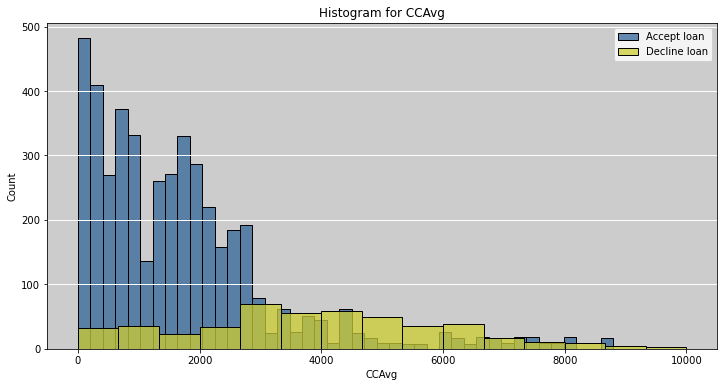

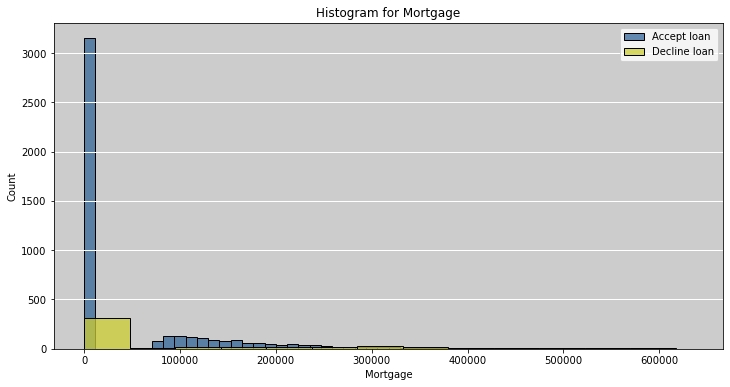

In [42]:
'''
It is better but not perfect
'''
for i in ["CCAvg", "Mortgage"]:
    plt.figure(figsize=(12,6))
    decline_loan= loans[loans["Personal Loan"]==0]
    accept_loan= loans[loans["Personal Loan"]==1]
    sns.histplot(decline_loan[i], kde=False, color=(0.2, 0.4, 0.6, 0.6))
    sns.histplot(accept_loan[i], kde=False, color=(0.8, 0.8, 0.2, 0.2))
    plt.legend(["Accept loan", "Decline loan"])
    plt.grid(True,axis='y', color='w', linestyle='-', linewidth=1)
    plt.gca().patch.set_facecolor('0.8')
    plt.title("Histogram for {}".format(i))
    plt.show()

In [43]:
'''
Prepare for classification.
'''
features = loans.drop('Personal Loan', axis=1)
target = loans['Personal Loan']

In [44]:
'''
Split the features into Training Dataset, Validation Dataset, Test Dataset.
'''
x_train, x_test, y_train,y_test = train_test_split(features, target,test_size=0.15,random_state=42)
x_train, x_val, y_train,y_val = train_test_split(x_train, y_train,test_size=0.15,random_state=42)

In [45]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(3612, 12)
(3612,)
(638, 12)
(638,)
(750, 12)
(750,)


In [46]:
'''
Fix the imbalance only to training dataset using Adasyn oversampler.
'''
adasyn = ADASYN()
x_adasyn, y_adasyn = adasyn.fit_resample(x_train, y_train)

In [47]:
print(x_adasyn.shape)
print(y_adasyn.shape)

(6502, 12)
(6502,)


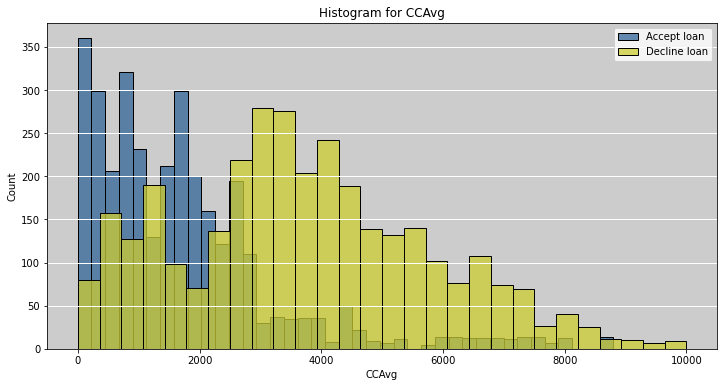

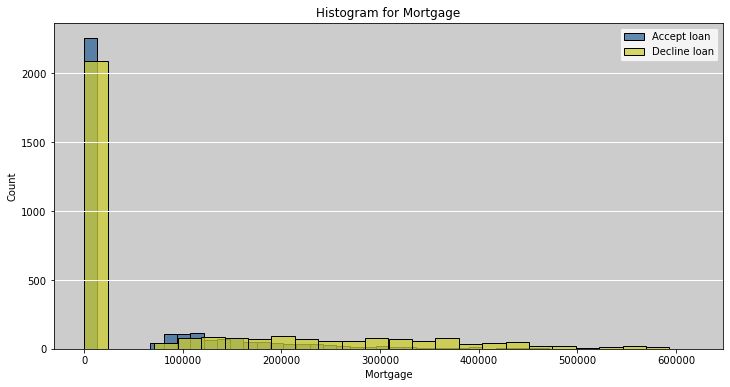

In [48]:
'''
Merge features with targets after oversampling so as to see the results.
Adasyn has done a very good job.
'''
loans_resampled = x_adasyn.merge(y_adasyn, left_index=True, right_index=True)

for i in ["CCAvg", "Mortgage"]:
    plt.figure(figsize=(12,6))
    decline_loan= loans_resampled[loans_resampled["Personal Loan"]==0]
    accept_loan= loans_resampled[loans_resampled["Personal Loan"]==1]
#     sns.set(style = 'darkgrid', palette= 'muted')
    sns.histplot(decline_loan[i], kde=False, color=(0.2, 0.4, 0.6, 0.6))
    sns.histplot(accept_loan[i], kde=False, color=(0.8, 0.8, 0.2, 0.2))
    plt.legend(["Accept loan", "Decline loan"])
    plt.grid(True,axis='y', color='w', linestyle='-', linewidth=1)
    plt.gca().patch.set_facecolor('0.8')
    plt.title("Histogram for {}".format(i))
    plt.show()

In [49]:
'''
I use MinmaxScaler cause i don't have negative values in my dataset.
'''
mm = MinMaxScaler()
x_train_scaled = mm.fit_transform(x_adasyn)
x_val_scaled = mm.transform(x_val)
x_test_scaled = mm.transform(x_test)

In [52]:
(x_train_scaled.shape[1],)

(12,)

In [51]:
pd.DataFrame(x_train_scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.613636,0.565217,0.357143,0.944358,0.000000,0.267,0.5,0.000000,0.0,1.0,1.0,1.0
1,0.500000,0.521739,0.242857,0.977697,0.333333,0.250,0.0,0.251216,0.0,0.0,1.0,0.0
2,0.318182,0.304348,0.066667,0.924254,0.666667,0.010,0.5,0.184765,0.0,0.0,0.0,0.0
3,0.068182,0.108696,0.204762,0.947930,1.000000,0.260,0.0,0.000000,0.0,0.0,1.0,0.0
4,0.363636,0.391304,0.257143,0.969134,1.000000,0.240,0.0,0.139384,0.0,0.0,0.0,0.0


In [53]:
tf.random.set_seed(13)

In [64]:
input_shape=(x_train_scaled.shape[1],)

model = tf.keras.Sequential(
      [Dense(128, activation="relu",input_shape = input_shape),
       Dropout(0.2),
       Dense(64, activation="relu"),
       Dropout(0.2),
       Dense(1, activation="sigmoid"),
      ]
  )
model.summary()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=2, min_lr=0.0005)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train_scaled, y_adasyn,
        epochs=45,
        validation_data=(x_val_scaled,y_val),
        callbacks=[reduce_lr],
        shuffle=True
         )
score = model.evaluate(x_test_scaled, y_test)
print('loss={}, acc={}'.format(score[0],score[1]))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1664      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 9,985
Trainable params: 9,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/45
204/204 [==============================] - 1s 2ms/step - loss: 0.4241 - accuracy: 0.8173 - val_loss: 0.2423

In [65]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,accuracy,val_loss,val_accuracy,lr,epoch
0,0.424088,0.817287,0.242345,0.899687,0.001,0
1,0.216257,0.914949,0.157690,0.932602,0.001,1
2,0.177838,0.923408,0.156936,0.931035,0.001,2
3,0.164667,0.927868,0.106542,0.962382,0.001,3
4,0.158188,0.930329,0.140791,0.945141,0.001,4


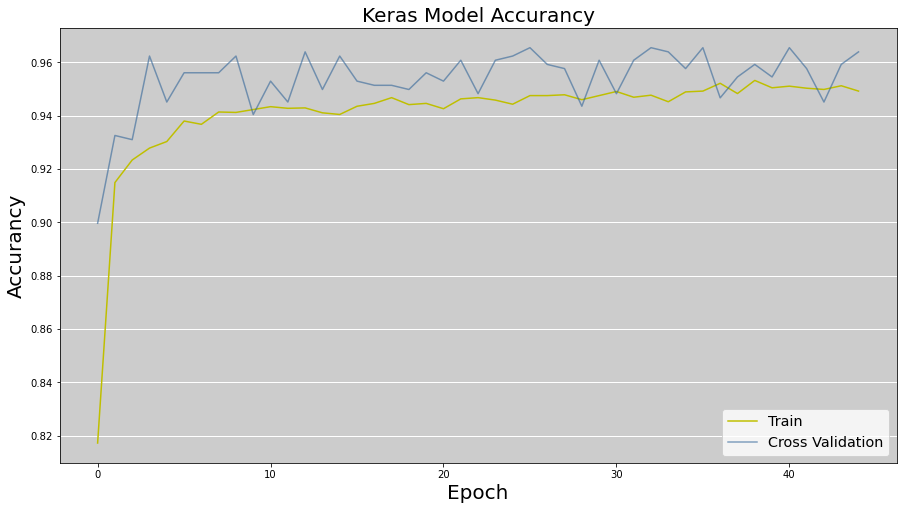

In [66]:
plt.figure(figsize=(15,8))
plt.plot(history.history['accuracy'], color='y')
plt.plot(history.history['val_accuracy'], color=(0.2, 0.4, 0.6, 0.6))
plt.title('Keras Model Accurancy',size=20)
plt.ylabel('Accurancy',size=20)
plt.xlabel('Epoch',size=20)
plt.grid(True,axis='y', color='w', linestyle='-', linewidth=1)
plt.gca().patch.set_facecolor('0.8')
plt.legend(['Train', 'Cross Validation'],fontsize='x-large', loc='lower right')
plt.show()

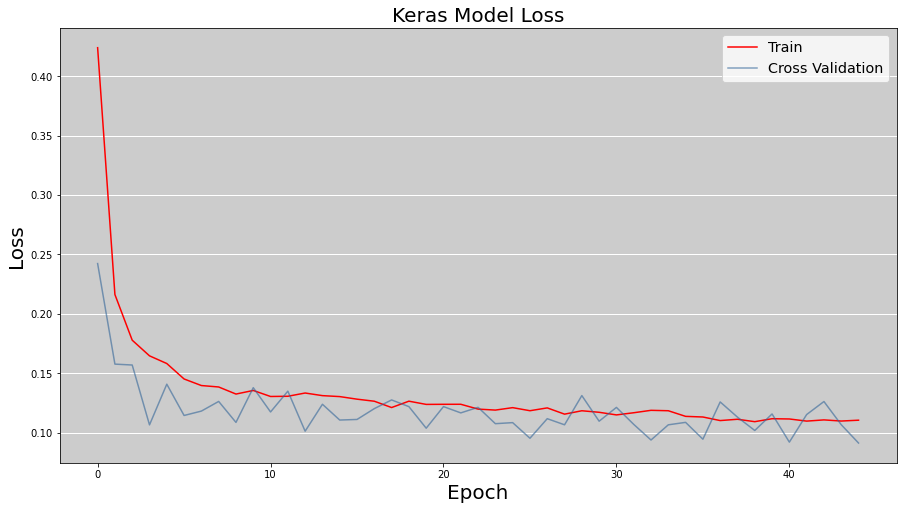

In [67]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color=(0.2, 0.4, 0.6, 0.6))
plt.title('Keras Model Loss',size=20)
plt.ylabel('Loss',size=20)
plt.xlabel('Epoch',size=20)
plt.grid(True,axis='y', color='w', linestyle='-', linewidth=1)
plt.gca().patch.set_facecolor('0.8')
plt.legend(['Train', 'Cross Validation'],fontsize='x-large', loc='upper right')
plt.show()

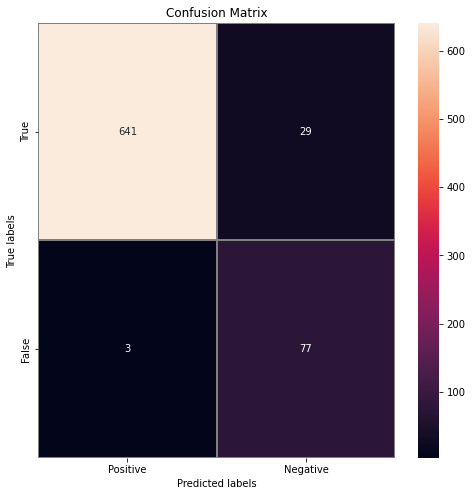

In [83]:
'''
Plot a heatmap in order to see the correct and wrong classifications.
'''
fig, ax=plt.subplots(figsize=(8,8))
predict_results = model.predict(x_test_scaled)
predict_results = (predict_results >0.5)
cm = confusion_matrix(y_test, predict_results)
sns.heatmap(cm,
            fmt='.0f',
            linewidths=0.1,
            linecolor='gray',
            annot=True,
            ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Positive', 'Negative'])
ax.yaxis.set_ticklabels(['True', 'False'])
plt.show()

In [69]:
'''
Tak a sample of 750 values.
'''
background = x_train_scaled[np.random.choice(x_train_scaled.shape[0], 750, replace=False)]

In [84]:
'''
Apply DeepExplainer to see which feautures affected most for the results.
'''
cols = list(features.columns)
explainer = shap.DeepExplainer(model,  background)
shap_values = explainer.shap_values(x_test_scaled)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [85]:
shap_values[0].shape

(750, 12)

In [88]:
shap_df = pd.DataFrame(shap_values[0], columns=cols)

In [95]:
shap_df.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
0,0.008934,-0.001787,-0.290917,0.001284,0.007369,-0.090327,0.004278,0.004006,-0.100050,-0.010550,0.026977,-0.042768
1,0.008994,0.006934,0.261221,0.000634,0.110962,0.093620,-0.006957,-0.000836,0.021371,-0.008902,0.074503,-0.048972
2,-0.065366,-0.037368,0.053009,-0.004142,-0.003267,0.048637,-0.177917,-0.090990,0.011703,-0.030489,-0.044163,0.051300
3,0.003958,0.005036,-0.188483,-0.003956,-0.008849,-0.062552,-0.046591,0.002820,-0.142977,-0.015824,-0.039086,0.012956
4,-0.018876,-0.001949,-0.366250,-0.002532,-0.004156,-0.078332,0.003134,-0.000664,0.003396,-0.012638,-0.014022,0.009337


In [94]:
shap_df.shape

(750, 12)

In [91]:
background_df = pd.DataFrame(background, columns=cols)

In [96]:
background_df.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
0,0.295455,0.260870,0.538095,0.944484,0.666667,0.223855,0.5,0.000000,0.0,0.0,0.0,0.0
1,0.477273,0.500000,0.585714,0.932062,0.000000,0.490000,1.0,0.000000,0.0,0.0,1.0,0.0
2,0.295455,0.282609,0.833333,0.985082,0.333333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.409091,0.434783,0.161905,0.945720,1.000000,0.220000,0.5,0.299838,1.0,0.0,1.0,0.0
4,0.863636,0.826087,0.142857,0.958303,0.333333,0.100000,1.0,0.000000,0.0,0.0,0.0,0.0


In [93]:
background_df.shape

(750, 12)

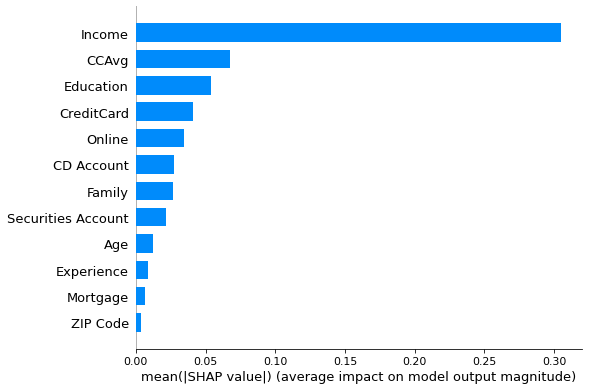

In [78]:
'''
Feauture of income affected the most.
'''
shap.summary_plot(shap_df,
                  background_df,
                  show=True,
                  plot_type="bar",
                  axis_color='black',
                 cmap='BlueRed')

In [99]:
model.predict(x_test_scaled)

array([[1.60848685e-08],
       [9.96124148e-01],
       [1.94498807e-01],
       [4.88905835e-06],
       [9.93282327e-08],
       [6.56574965e-04],
       [2.87616938e-01],
       [2.12213397e-03],
       [6.57847352e-07],
       [1.14396363e-01],
       [1.56327857e-07],
       [1.43199049e-05],
       [4.13488448e-02],
       [1.66888040e-05],
       [7.84473479e-01],
       [7.78077483e-01],
       [1.27246976e-03],
       [2.11451083e-01],
       [9.55313681e-07],
       [9.99998569e-01],
       [3.28551515e-08],
       [6.77795351e-01],
       [8.75085592e-03],
       [1.52857602e-02],
       [1.75381945e-06],
       [1.17964209e-05],
       [2.48797678e-05],
       [2.65646487e-01],
       [9.67142582e-02],
       [8.94546509e-04],
       [1.93692088e-01],
       [5.25667621e-10],
       [9.99591112e-01],
       [1.31711364e-03],
       [2.51591337e-06],
       [7.73757984e-06],
       [1.09120083e-05],
       [3.03434972e-05],
       [9.82261481e-05],
       [4.14291378e-07],


roc_auc_score for Model:  0.9935261194029852


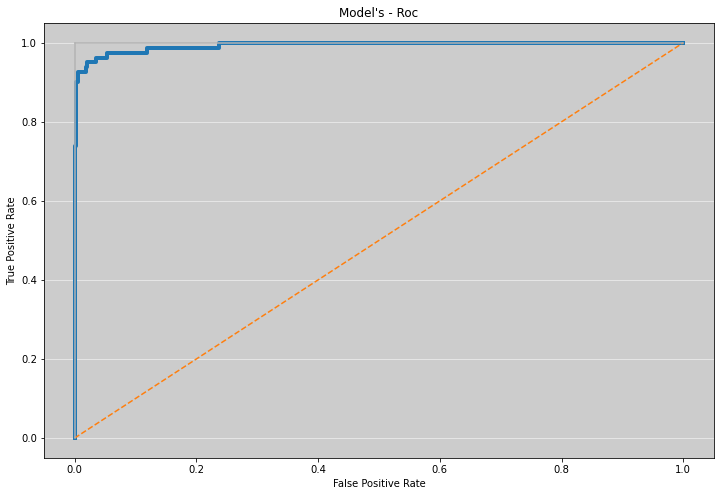

In [100]:
'''
Create the Roc curve of the predictions.
'''
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, model.predict(x_test_scaled))
print('roc_auc_score for Model: ', roc_auc_score(y_test, model.predict(x_test_scaled)))

plt.figure(figsize=(12,8))
plt.title("Model's - Roc")
plt.plot(false_positive_rate, true_positive_rate, linewidth=4)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(True,axis='y', color='w', linestyle='-', linewidth=0.5)
plt.gca().patch.set_facecolor('0.8')
plt.show()